# LightGCN V5 - In-batch Negative Sampling

## Breakthrough: In-batch Negative Sampling
- **기존**: 전체 아이템에서 랜덤 negative 샘플링
- **개선**: 배치 내의 다른 user의 positive item을 negative로 사용
- **효과**: 더 어려운 negative → 더 강한 구분력

## V4 최적 설정 사용
- emb_dim: 32
- n_layers: 1
- lr: 5e-3
- weight_decay: 1e-5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. 데이터 전처리 (V4와 동일)

In [2]:
df = pd.read_csv('data/train.csv')

user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)
df['label'] = (df['rating'] >= 4.0).astype(int)

positive_df = df[df['label'] == 1].copy()

# Train/Val Split
train_data, val_data = [], []
for user_idx in range(n_users):
    user_pos = positive_df[positive_df['user_idx'] == user_idx]
    if len(user_pos) >= 2:
        user_pos = user_pos.sample(frac=1, random_state=SEED).reset_index(drop=True)
        split_idx = max(1, int(0.8 * len(user_pos)))
        train_data.append(user_pos.iloc[:split_idx])
        val_data.append(user_pos.iloc[split_idx:])
    elif len(user_pos) == 1:
        train_data.append(user_pos)

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True)

print(f"Users: {n_users}, Items: {n_items}")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}")

Users: 668, Items: 10321
Train: 41,214, Val: 10,616


In [3]:
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)
val_users = torch.LongTensor(val_df['user_idx'].values)
val_items = torch.LongTensor(val_df['item_idx'].values)

user_pos_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_pos_items[int(u)].add(int(i))

user_neg_candidates = {}
for u in range(n_users):
    pos = user_pos_items[u]
    user_neg_candidates[u] = np.array(list(set(range(n_items)) - pos))

print(f"Pre-computed negative candidates")

Pre-computed negative candidates


In [4]:
def build_graph():
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    edge_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_graph()
print(f"Graph: {edge_index.shape[1]:,} edges")

Graph: 82,428 edges


## 2. 모델 (V4 최적 설정)

In [5]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=32, n_layers=1):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(0, row.unsqueeze(1).expand(-1, self.emb_dim), messages)
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]

def bpr_loss(pos_scores, neg_scores):
    """BPR loss with multiple negatives"""
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

# V4 최적 설정
EMB_DIM = 32
N_LAYERS = 1

model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
print(f"LightGCN: emb={EMB_DIM}, layers={N_LAYERS}, params={sum(p.numel() for p in model.parameters()):,}")

LightGCN: emb=32, layers=1, params=351,648


## 3. In-batch Negative Sampling (핵심 변경)

In [6]:
def in_batch_negative_sampling(pos_users, pos_items, num_neg=4):
    """
    **Breakthrough: In-batch Negative Sampling**
    
    배치 내의 다른 user의 positive item을 negative로 사용
    + 일부는 random negative도 섞음 (다양성 유지)
    
    Args:
        pos_users: [batch_size] - user indices
        pos_items: [batch_size] - positive item indices
        num_neg: number of negatives per positive
    
    Returns:
        neg_items: [batch_size, num_neg]
    """
    batch_size = len(pos_users)
    neg_items = np.zeros((batch_size, num_neg), dtype=np.int64)
    
    # In-batch negatives 수 (절반)
    n_inbatch = num_neg // 2
    n_random = num_neg - n_inbatch
    
    pos_items_np = pos_items.cpu().numpy() if torch.is_tensor(pos_items) else pos_items
    pos_users_np = pos_users.cpu().numpy() if torch.is_tensor(pos_users) else pos_users
    
    for i in range(batch_size):
        user_idx = int(pos_users_np[i])
        user_pos_set = user_pos_items[user_idx]
        
        # 1. In-batch negatives (다른 user의 positive items)
        in_batch_candidates = []
        for j in range(batch_size):
            if j != i:  # 자기 자신 제외
                item_j = int(pos_items_np[j])
                # 현재 user가 이미 본 아이템이 아니어야 함
                if item_j not in user_pos_set:
                    in_batch_candidates.append(item_j)
        
        # In-batch에서 샘플링
        if len(in_batch_candidates) >= n_inbatch:
            selected_inbatch = np.random.choice(in_batch_candidates, size=n_inbatch, replace=False)
        else:
            # In-batch 후보가 부족하면 random으로 대체
            selected_inbatch = np.array(in_batch_candidates) if in_batch_candidates else np.array([], dtype=np.int64)
            n_random += (n_inbatch - len(selected_inbatch))
        
        # 2. Random negatives
        cands = user_neg_candidates[user_idx]
        # In-batch에서 이미 선택된 것 제외
        if len(selected_inbatch) > 0:
            cands = np.setdiff1d(cands, selected_inbatch)
        selected_random = np.random.choice(cands, size=min(n_random, len(cands)), replace=False)
        
        # 합치기
        all_neg = np.concatenate([selected_inbatch, selected_random])
        
        # 부족하면 random으로 채우기
        while len(all_neg) < num_neg:
            extra = np.random.choice(cands, size=1, replace=False)
            all_neg = np.concatenate([all_neg, extra])
        
        neg_items[i] = all_neg[:num_neg]
    
    return torch.LongTensor(neg_items)

# 테스트
test_u = train_users[:10]
test_i = train_items[:10]
test_neg = in_batch_negative_sampling(test_u, test_i, num_neg=4)
print(f"Sample in-batch negatives shape: {test_neg.shape}")
print(f"Sample: user={test_u[0].item()}, pos_item={test_i[0].item()}, neg_items={test_neg[0].numpy()}")

Sample in-batch negatives shape: torch.Size([10, 4])
Sample: user=0, pos_item=15, neg_items=[8824 7858 3694  326]


## 4. 평가 함수 (V4와 동일)

In [7]:
@torch.no_grad()
def evaluate(model, k=10, n_neg=99, sample_size=5000):
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    if len(val_df) > sample_size:
        sample_idx = np.random.choice(len(val_df), sample_size, replace=False)
    else:
        sample_idx = np.arange(len(val_df))
    
    hits, ndcgs = [], []
    
    for idx in sample_idx:
        user_idx = int(val_users[idx])
        pos_item = int(val_items[idx])
        
        cands = user_neg_candidates[user_idx]
        if len(cands) < n_neg:
            continue
        neg_items = np.random.choice(cands, size=n_neg, replace=False)
        candidates = np.concatenate([[pos_item], neg_items])
        
        u_t = torch.full((len(candidates),), user_idx, dtype=torch.long, device=device)
        i_t = torch.LongTensor(candidates).to(device)
        scores = (u_emb[u_t] * i_emb[i_t]).sum(dim=1).cpu().numpy()
        
        rank = (scores > scores[0]).sum() + 1
        hits.append(1.0 if rank <= k else 0.0)
        ndcgs.append(1.0 / np.log2(rank + 1) if rank <= k else 0.0)
    
    return np.mean(hits), np.mean(ndcgs)

print("Evaluation function ready")

Evaluation function ready


## 5. 학습 (In-batch Negative 적용)

In [8]:
# Hyperparameters (V4 최적값)
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024  # In-batch sampling을 위해 큰 배치
NUM_NEG = 4

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {'loss': [], 'hit@10': [], 'ndcg@10': []}
best_hit = 0
n_train = len(train_users)

print(f"Training with In-batch Negative Sampling")
print(f"Config: BS={BATCH_SIZE}, LR={LR}, NEG={NUM_NEG} (50% in-batch, 50% random)")
print("=" * 60)

start_time = time.time()

Training with In-batch Negative Sampling
Config: BS=1024, LR=0.005, NEG=4 (50% in-batch, 50% random)


In [9]:
for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_users[batch_idx].to(device)
        pos_i = train_items[batch_idx].to(device)
        
        # **핵심: In-batch Negative Sampling**
        neg_i = in_batch_negative_sampling(pos_u, pos_i, NUM_NEG).to(device)
        
        # Forward
        u_emb, i_emb = model(edge_index, edge_weight)
        
        # Scores
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_u_expanded = pos_u.unsqueeze(1).expand(-1, NUM_NEG)
        neg_scores = (u_emb[neg_u_expanded] * i_emb[neg_i]).sum(dim=2)
        
        loss = bpr_loss(pos_scores, neg_scores)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    history['loss'].append(avg_loss)
    
    # Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0:
        hit, ndcg = evaluate(model, sample_size=5000)
        history['hit@10'].append(hit)
        history['ndcg@10'].append(ndcg)
        
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.4f} | Hit@10: {hit:.4f} | NDCG@10: {ndcg:.4f}")
        
        if hit > best_hit:
            best_hit = hit
            best_ndcg = ndcg
            torch.save(model.state_dict(), 'best_lightgcn_v5.pt')

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes")
print(f"Best Hit@10: {best_hit:.4f}, NDCG@10: {best_ndcg:.4f}")

Epoch   5 | Loss: 0.2950 | Hit@10: 0.7690 | NDCG@10: 0.5059
Epoch  10 | Loss: 0.2091 | Hit@10: 0.7710 | NDCG@10: 0.5157
Epoch  15 | Loss: 0.1697 | Hit@10: 0.7756 | NDCG@10: 0.5251
Epoch  20 | Loss: 0.1462 | Hit@10: 0.7704 | NDCG@10: 0.5189
Epoch  25 | Loss: 0.1307 | Hit@10: 0.7738 | NDCG@10: 0.5208
Epoch  30 | Loss: 0.1238 | Hit@10: 0.7568 | NDCG@10: 0.5136
Epoch  35 | Loss: 0.1157 | Hit@10: 0.7534 | NDCG@10: 0.5127
Epoch  40 | Loss: 0.1115 | Hit@10: 0.7632 | NDCG@10: 0.5145
Epoch  45 | Loss: 0.1083 | Hit@10: 0.7566 | NDCG@10: 0.5156
Epoch  50 | Loss: 0.1055 | Hit@10: 0.7624 | NDCG@10: 0.5161

Training completed in 22.8 minutes
Best Hit@10: 0.7756, NDCG@10: 0.5251


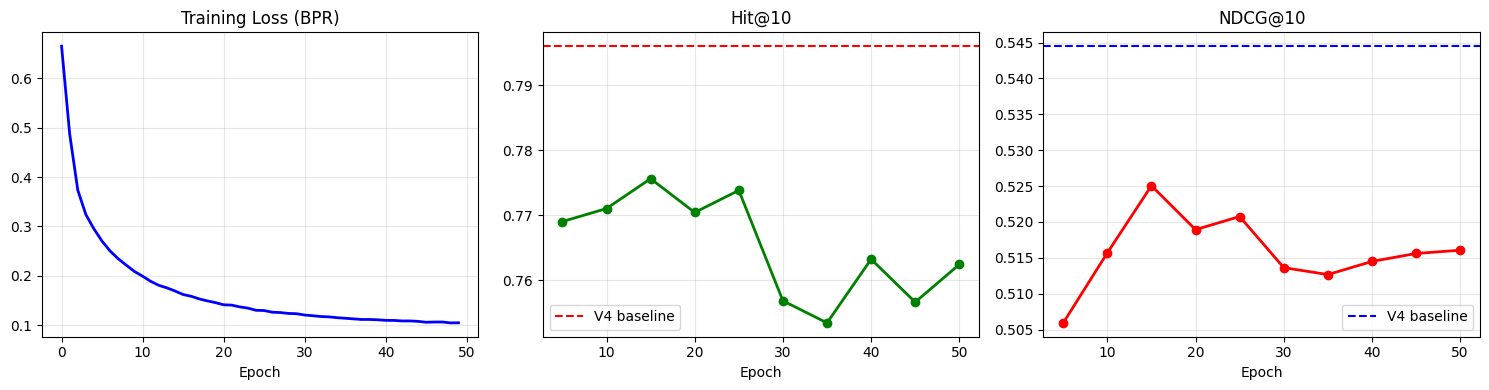

In [10]:
# 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Training Loss (BPR)')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

epochs_val = np.arange(5, EPOCHS+1, 5)[:len(history['hit@10'])]
axes[1].plot(epochs_val, history['hit@10'], 'g-o', linewidth=2)
axes[1].axhline(y=0.7960, color='red', linestyle='--', label='V4 baseline')
axes[1].set_title('Hit@10')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(epochs_val, history['ndcg@10'], 'r-o', linewidth=2)
axes[2].axhline(y=0.5445, color='blue', linestyle='--', label='V4 baseline')
axes[2].set_title('NDCG@10')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Threshold & O/X 추론

In [11]:
# Load best model
model.load_state_dict(torch.load('best_lightgcn_v5.pt'))
model.eval()

with torch.no_grad():
    u_emb, i_emb = model(edge_index, edge_weight)

# Positive scores
val_scores = (u_emb[val_users.to(device)] * i_emb[val_items.to(device)]).sum(dim=1).cpu().numpy()

# Negative scores
neg_scores_list = []
for user_idx in val_df['user_idx'].unique():
    n_pos = (val_df['user_idx'] == user_idx).sum()
    cands = user_neg_candidates[int(user_idx)]
    neg_items = np.random.choice(cands, size=min(n_pos, len(cands)), replace=False)
    
    u_t = torch.full((len(neg_items),), user_idx, dtype=torch.long, device=device)
    i_t = torch.LongTensor(neg_items).to(device)
    scores = (u_emb[u_t] * i_emb[i_t]).sum(dim=1).cpu().numpy()
    neg_scores_list.extend(scores)

all_scores = np.concatenate([val_scores, np.array(neg_scores_list)])
all_labels = np.concatenate([np.ones(len(val_scores)), np.zeros(len(neg_scores_list))])

print(f"Total: {len(all_scores)} (Pos: {int(all_labels.sum())}, Neg: {len(all_labels)-int(all_labels.sum())})")

Total: 21232 (Pos: 10616, Neg: 10616)


In [12]:
# Threshold tuning
thresholds = np.percentile(all_scores, [30, 40, 50, 60, 70, 80, 90])

print("Threshold Tuning:")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 50)

best_prec, best_th, best_f1 = 0, 0, 0
for th in thresholds:
    preds = (all_scores >= th).astype(int)
    tp = ((preds == 1) & (all_labels == 1)).sum()
    fp = ((preds == 1) & (all_labels == 0)).sum()
    fn = ((preds == 0) & (all_labels == 1)).sum()
    
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    
    print(f"{th:<12.4f} {prec:<12.4f} {rec:<12.4f} {f1:<12.4f}")
    
    if prec >= 0.6 and prec > best_prec:
        best_prec, best_th, best_f1 = prec, th, f1
    elif best_prec < 0.6 and f1 > best_f1:
        best_f1, best_th, best_prec = f1, th, prec

print("-" * 50)
print(f"Selected: {best_th:.4f} (Precision: {best_prec:.4f})")

Threshold Tuning:
Threshold    Precision    Recall       F1          
--------------------------------------------------
-0.0843      0.6665       0.9331       0.7776      
0.0709       0.7545       0.9053       0.8230      
0.7309       0.8408       0.8408       0.8408      
1.4732       0.8998       0.7199       0.7998      
2.1146       0.9367       0.5621       0.7026      
2.7042       0.9557       0.3823       0.5462      
3.4136       0.9718       0.1944       0.3240      
--------------------------------------------------
Selected: 3.4136 (Precision: 0.9718)


In [13]:
def predict_ox(test_df):
    results = []
    
    known_mask = test_df['user'].isin(user2idx) & test_df['item'].isin(item2idx)
    known_df = test_df[known_mask]
    unknown_df = test_df[~known_mask]
    
    if len(known_df) > 0:
        u_idx = torch.LongTensor([user2idx[u] for u in known_df['user']]).to(device)
        i_idx = torch.LongTensor([item2idx[i] for i in known_df['item']]).to(device)
        
        with torch.no_grad():
            scores = (u_emb[u_idx] * i_emb[i_idx]).sum(dim=1).cpu().numpy()
        
        for (_, row), score in zip(known_df.iterrows(), scores):
            results.append({
                'user': row['user'], 'item': row['item'],
                'recommend': 'O' if score >= best_th else 'X'
            })
    
    for _, row in unknown_df.iterrows():
        results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
    
    return pd.DataFrame(results)

# Test
preds = predict_ox(val_df[['user', 'item']])
o_ratio = (preds['recommend'] == 'O').mean()
print(f"\nO ratio: {100*o_ratio:.1f}%")
print(preds.head(10).to_string(index=False))


O ratio: 19.4%
 user  item recommend
    1  1221         O
    1  6365         X
    1   527         X
    1  1220         X
    1  1196         O
    1 54286         X
    1  1210         X
    1   318         O
    1  3578         O
    1   968         X


## 7. 최종 결과 요약

In [14]:
print("=" * 60)
print("LightGCN V5 Final Summary")
print("=" * 60)

print(f"\nBreakthrough: In-batch Negative Sampling")
print(f"  50% in-batch negatives (harder)")
print(f"  50% random negatives (diversity)")

print(f"\nModel Config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nPerformance:")
print(f"  Best Hit@10: {best_hit:.4f}")
print(f"  Best NDCG@10: {best_ndcg:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  O ratio: {100*o_ratio:.1f}%")

print(f"\nV4 → V5 Comparison:")
print(f"  V4 Hit@10: 0.7960")
print(f"  V5 Hit@10: {best_hit:.4f}")
print(f"  Δ Hit@10: {100*(best_hit - 0.7960)/0.7960:+.2f}%")
print(f"")
print(f"  V4 NDCG@10: 0.5445")
print(f"  V5 NDCG@10: {best_ndcg:.4f}")
print(f"  Δ NDCG@10: {100*(best_ndcg - 0.5445)/0.5445:+.2f}%")

LightGCN V5 Final Summary

Breakthrough: In-batch Negative Sampling
  50% in-batch negatives (harder)
  50% random negatives (diversity)

Model Config:
  emb_dim: 32
  n_layers: 1
  Parameters: 351,648

Performance:
  Best Hit@10: 0.7756
  Best NDCG@10: 0.5251
  Precision: 0.9718
  O ratio: 19.4%

V4 → V5 Comparison:
  V4 Hit@10: 0.7960
  V5 Hit@10: 0.7756
  Δ Hit@10: -2.56%

  V4 NDCG@10: 0.5445
  V5 NDCG@10: 0.5251
  Δ NDCG@10: -3.57%


In [15]:
# Test inference
# test_df = pd.read_csv('data/test.csv')
# final_preds = predict_ox(test_df)
# final_preds.to_csv('predictions_gnn_v5.csv', index=False)

print("Test inference ready.")

Test inference ready.
